In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base= automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
# data only goes up to 2018

vacay_start = '2018-08-01'
vacay_end = '2018-08-07'

vacay_start = dt.datetime.strptime(vacay_start, '%Y-%m-%d')
vacay_end =  dt.datetime.strptime(vacay_end, '%Y-%m-%d')

last_yr_start = vacay_start - dt.timedelta(365)
last_yr_end = vacay_end - dt.timedelta(365)

In [11]:
ttemps = calc_temps(last_yr_start, last_yr_end)

min_temp = ttemps[0][0]
avg_temp = ttemps[0][1]
max_temp = ttemps[0][2]

print(f'Min Temp: {min_temp} F')
print(f'Avg Temp: {avg_temp} F')
print(f'Max Temp: {max_temp} F')

Min Temp: 73.0 F
Avg Temp: 80.04166666666667 F
Max Temp: 83.0 F


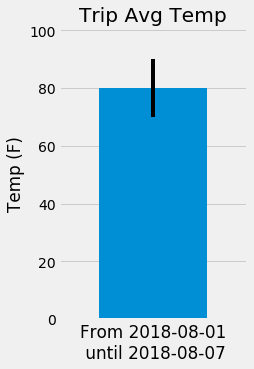

In [12]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_value = [1]
y_value = avg_temp
error = (max_temp-min_temp)

plt.figure(figsize=(3,5))
plt.bar(x_value, y_value, yerr=error)

plt.title("Trip Avg Temp")

plt.xlim(0.3, 1.7)
plt.tick_params(axis='x', labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.xlabel(f'From 2018-08-01\n until 2018-08-07')

plt.ylim(0, 101)
plt.grid(which='major', axis='y', linestyle='-')
plt.ylabel("Temp (F)")

plt.show()

### Daily Rainfall Average

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
rf_data = [Station.station,Station.name,Station.latitude,Station.longitude,Station.\
           elevation, func.sum(Measurement.prcp)]

rf_query = session.query(*rf_data).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= last_yr_start).\
    filter(Measurement.date <= last_yr_end).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rf_df = pd.DataFrame(rf_query, columns=['Station','Name','Latitude','Longitude','Elevation','Prcp Amount'])
rf_df = rf_df.sort_values("Prcp Amount",ascending=False)
rf_df

,Station,Name,Latitude,Longitude,Elevation,Prcp Amount
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.10
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.02
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


### Daily Temperature Normals

In [14]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2018-07-01'
end_date = '2018-07-07'

# Use the start and end date to create a range of dates
range_date = pd.date_range(start = start_date, end = end_date)

# Strip off the year and save a list of strings in the format %m-%d
month_day_list = []
trip_days = []

for date in range_date:
    month_day_list.append(dt.datetime.strftime(date,'%m-%d'))   
    trip_days.append(dt.datetime.strftime(date,'%Y-%m-%d'))

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for month_day in month_day_list:
     normals.append(list(np.ravel(daily_normals(month_day))))

normals

[[67.0, 74.77777777777777, 81.0],
 [68.0, 75.40384615384616, 82.0],
 [68.0, 75.32075471698113, 87.0],
 [70.0, 76.57142857142857, 81.0],
 [66.0, 75.0, 81.0],
 [69.0, 75.0, 81.0],
 [69.0, 74.91071428571429, 82.0]]

In [16]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_weather_df = pd.DataFrame(normals, columns=['min_temp','avg_temp','max_temp'])
trip_weather_df['date'] = trip_days
trip_weather_df = trip_weather_df.set_index('date')
trip_weather_df

,min_temp,avg_temp,max_temp
date,,,
2018-07-01,67.0,74.777778,81.0
2018-07-02,68.0,75.403846,82.0
2018-07-03,68.0,75.320755,87.0
2018-07-04,70.0,76.571429,81.0
2018-07-05,66.0,75.000000,81.0
2018-07-06,69.0,75.000000,81.0
2018-07-07,69.0,74.910714,82.0


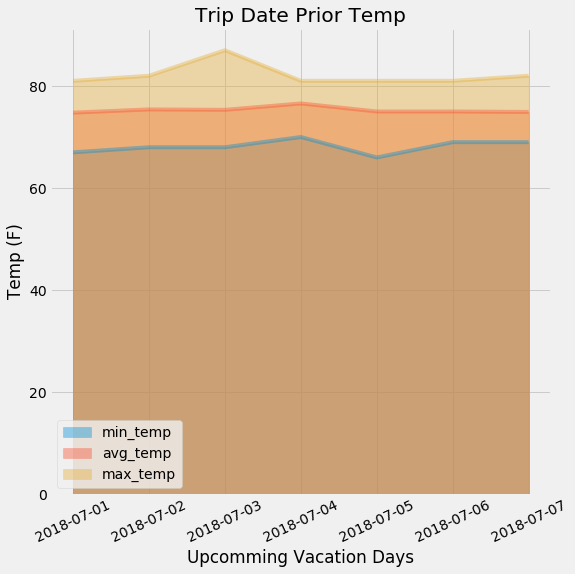

In [17]:
# Plot the daily normals as an area plot with `stacked=False`
trip_weather_df.plot.area(stacked=False, figsize=(8,8), alpha=0.4)
plt.xticks(rotation=25)
plt.xlabel(f'Upcomming Vacation Days')

plt.ylabel("Temp (F)")

plt.grid(which='major', linestyle='-')
plt.title("Trip Date Prior Temp")

plt.savefig("images/norm_temp_plot.png", bbox_inches='tight')
plt.show()

## Close Session

In [18]:
session.close()